## Latent Dirichlet Allocation

In [1]:
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from octis.preprocessing.preprocessing import Preprocessing
from skopt.space.space import Real, Integer
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from wordcloud import WordCloud
import os
import spacy
import string
from tqdm import tqdm


/home/nicovis/anaconda3/envs/OCTIS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Assuming the book is located in /notebooks we go back one level to the root directory in order to import the modules
# Get the current working directory

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

from preprocessing.clean_text import *

In [3]:
extract_corpus_and_labels_from_songs_csv(csv_input_path = 'data/raw/cleaned_train_lyrics.csv', output_path = 'data/input', frac = 0.25)

Corpus has been saved to data/input/corpus.txt
Labels have been saved to data/input/labels.txt


In [4]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 10,
                             max_df = 0.85,
                             remove_punctuation = True,
                             punctuation = string.punctuation,
                             remove_numbers = True,
                             lemmatize = True,
                             stopword_list = CUSTOM_STOPWORDS,
                             min_chars = 3,
                             min_words_docs = 10,
                             language = 'english',
                             split = True,
                             verbose = True)

In [5]:
# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists('data/processed/dataset'):
    dataset = preprocessor.preprocess_dataset(documents_path = 'data/input/corpus.txt',labels_path = 'data/input/labels.txt')
    dataset.save('data/processed/dataset')
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder('data/processed/dataset')

100%|██████████| 125000/125000 [1:12:28<00:00, 28.74it/s]


created vocab
24204
words filtering done


In [6]:
dataset.get_metadata()

124281
24204


## Metrics

In [17]:
dummy_run = False

if(dummy_run):
    num_iters = 5
    number_of_calls = 2
else:
    num_iters = 15
    number_of_calls = 15 # Bottleneck for computation time 10m calls approx 3 hours

In [8]:
dataset.get_info()

In [18]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk= 10, measure = 'c_uci') # Initialize metrics

## Without optimization

In [19]:
# Create Model, our  arbitrary assumption on the initial number of topics: 10 
model = LDA(num_topics=10)

In [21]:
coherence_list_no_opt, topic_diversity_list_no_opt = [], []

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:07<?, ?it/s]


KeyboardInterrupt: 

## With optimization

In [15]:
model = LDA()

In [ ]:
# Optimization for hyperparameters based on coherence (to be substituted with a combination of ch e td ?)

# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "decay" : Real(low=0.5001, high =1)}

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

if(number_of_calls == None):
    number_of_calls = len(search_space.keys())*5


print(number_of_calls)

30


In [ ]:

start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult = optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_LDA", # path to store the results
                            number_of_call = number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs = 5, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen = True, # plot the best seen value of the metric
                            extra_metrics = [td], # track also the topic diversity
                            plot_model = True, # plot the topic model
                            early_step = 10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model ='GP', # surrogate model for the optimization: gaussian process
                            random_state = 123,
                            save_models = True,
                            topk = 20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')
results = json.load(open("results/test_LDA/result.json",'r'))

Current call:  0
Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11


KeyboardInterrupt: 

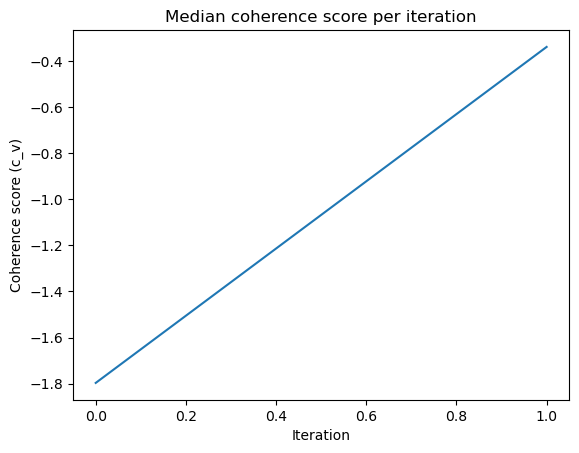

In [15]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_uci)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.show()

In [16]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


-0.33931893880475833


In [17]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
decay = results["x_iters"]["decay"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal decay: ", decay)

dict_keys(['decay', 'num_topics', 'offset'])
Optimal number of topics:  5
Optimal offset:  98
Optimal decay:  0.5308725786039316


Now we're ready to train it. Note that the output of a topic model comes as a dictionary composed of 4 elements:


*   *topics*: the list of word topics
*   *topic-word-matrix*: the distribution of the words of the vocabulary for each topic (dimensions: |num topics| x |vocabulary|)
*   *topic-document-matrix*: the distribution of the topics for each document of the training set (dimensions: |num topics| x |training documents|)
*   *test-document-topic-matrix*: the distribution of the topics for each document of the testing set (dimensions: |num topics| x |test documents|)



In [18]:
model = LDA(num_topics = num_topics, decay = decay)

In [ ]:
coherence_list, topic_diversity_list, outputs = [], [], []

for i in range(num_iters):
  output = model.train_model(dataset, top_words=10)
  outputs.append(output)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

Mean coherence:  -0.22610457143463564 
Mean topic diversity:  0.544


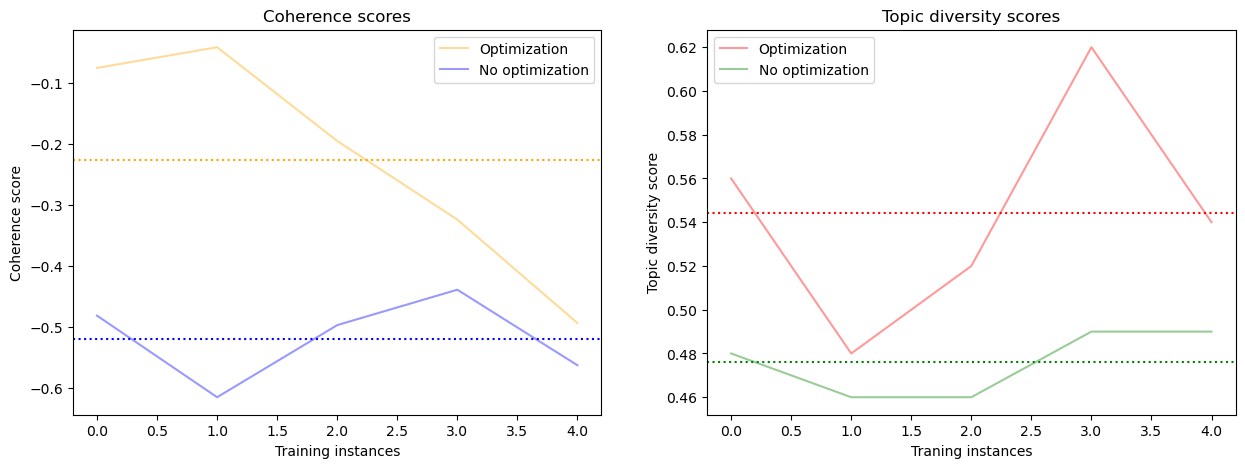

In [26]:

# Plot of the coherences of the models (no opt vs opt) and the topic diversity of the models (no opt vs opt). Both plots also show the mean values and the variance!
# Two plots side by side 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()


In [27]:
# Extract the best output from the outputs list according to a linear combination of the coherence and topic diversity scores

best_output = outputs[np.argmax([0.7*coherence_list[i] + 0.3*topic_diversity_list[i] for i in range(len(coherence_list))])]


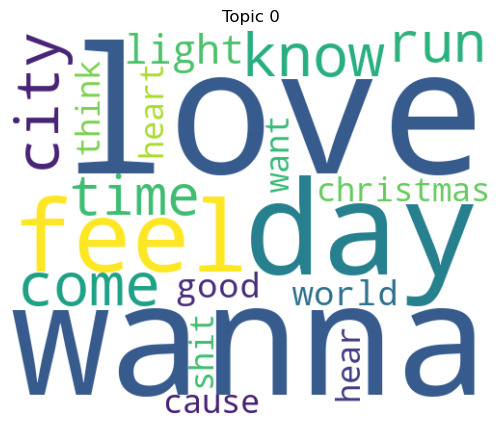

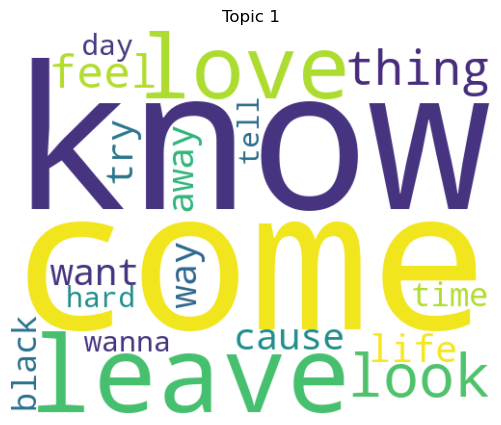

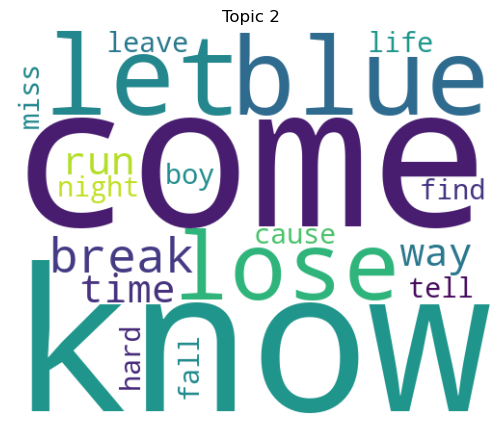

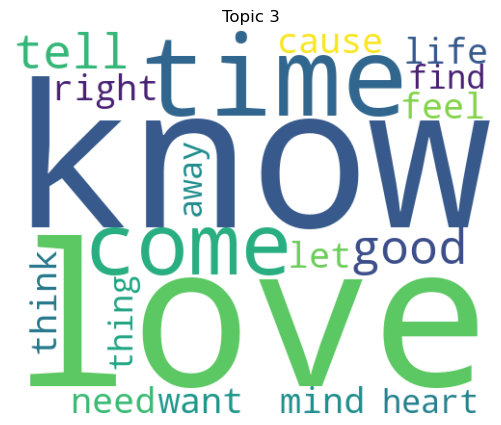

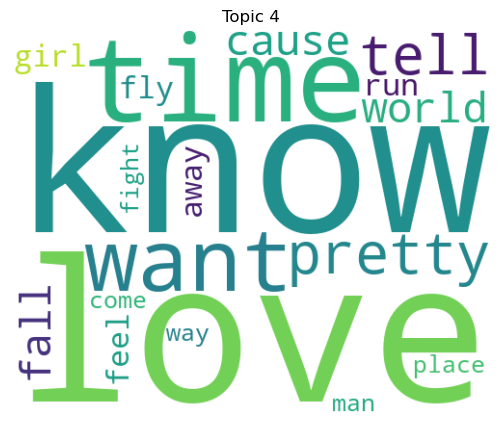

In [28]:
topics = best_output['topics']
for i, topic in enumerate(topics):
  wordcloud = WordCloud(width=500, height=400, background_color='white').generate(" ".join(topic))
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Topic {i}")
  plt.show()


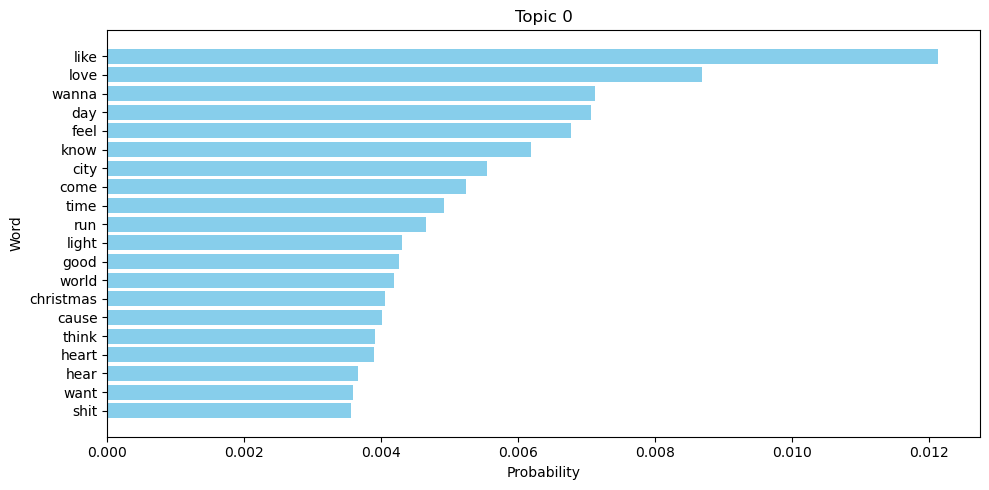

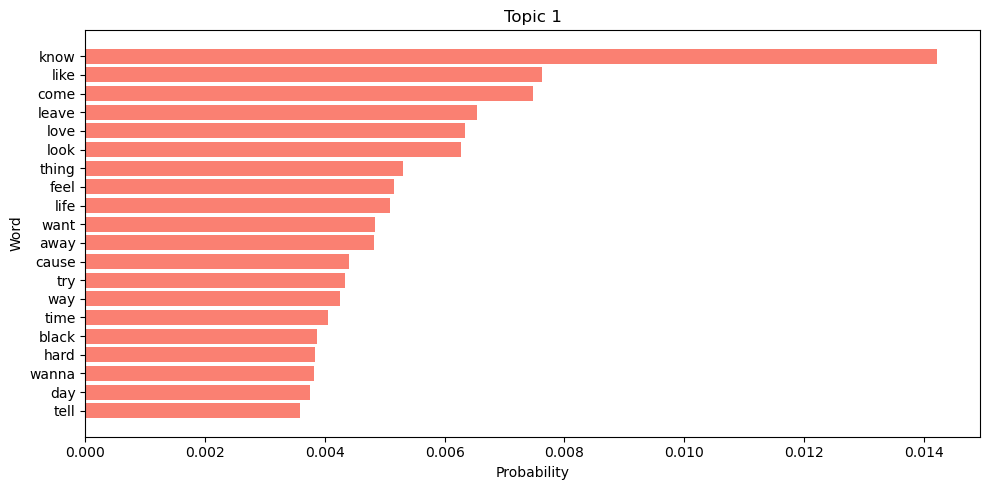

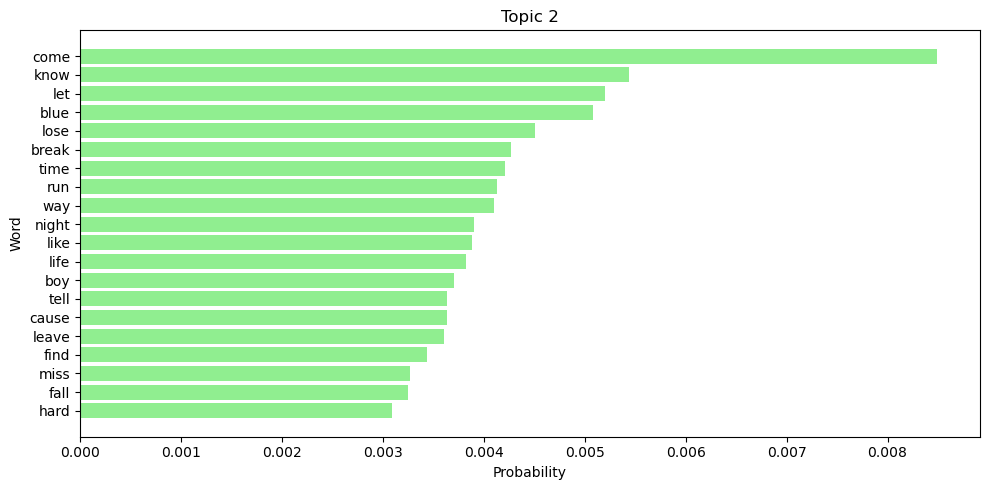

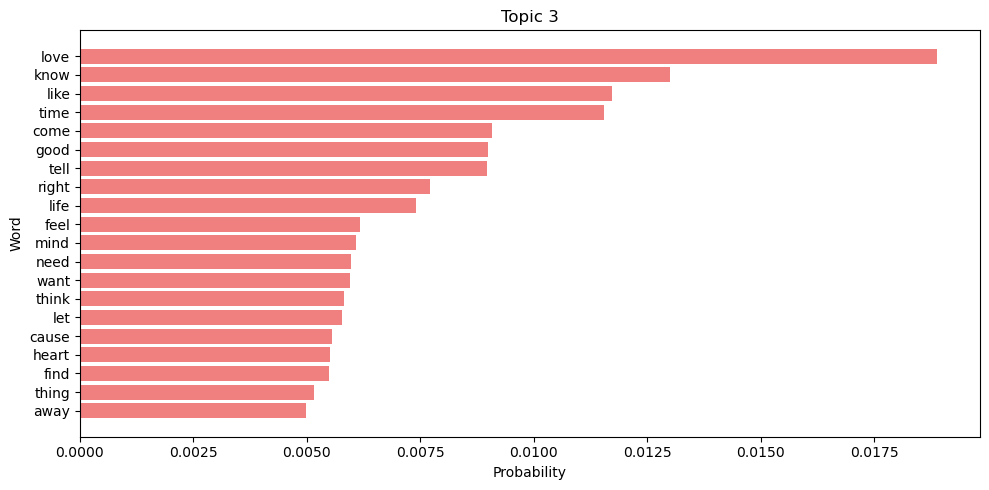

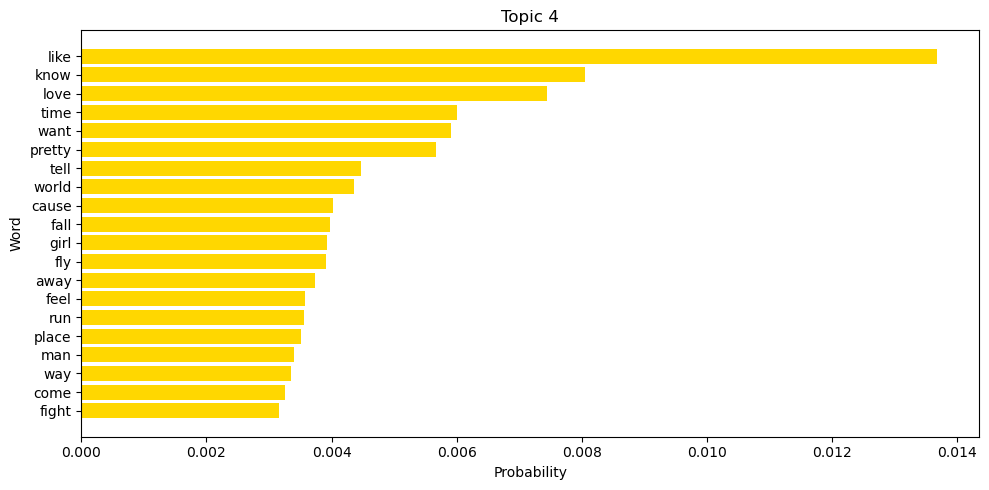

In [ ]:
topic_word_matrix = best_output['topic-word-matrix'] # The probability of each word for each topic
words = best_output['topics'] # The top words for each topic


colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold', 'orchid', 'cyan', 'peachpuff', 'cornflowerblue', 'palegreen']

# Number of words to display 
top_n_words = 10


# Display the top n words for each topic in a bar plot
for i, topic in enumerate(topic_word_matrix):
    # Get the top N words and their probabilities
    top_n_words_indices = np.argsort(topic)[::-1][:top_n_words]
    top_n_words_values = [topic[i] for i in top_n_words_indices]
    top_n_words_words = words[i]

    # Use a different color for each topic
    color = colors[i % len(colors)]  # Cycle through the list of colors

    # Create horizontal bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(top_n_words_words, top_n_words_values, color=color)
    plt.xlabel("Probability")
    plt.ylabel("Word")
    plt.title(f"Topic {i}")
    
    # Invert y-axis for readability
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()
